# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.neighbors import DistanceMetric
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering # for clustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alcohol-consumption-in-russia/russia_alcohol.csv


In [2]:
# For reading data in if saved locally
# df = pd.read_csv('/data/russian_alcohol_consumption.csv')
# df.head()

# Reading data in from Kaggle
df = pd.read_csv('/kaggle/input/alcohol-consumption-in-russia/russia_alcohol.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [3]:
# Set default parameters for graph and style
plt.rcParams.update({'font.size': 14, 'figure.figsize': (8,8), 'axes.titleweight': 'bold'})
# plt.rcParams()
sns.set_style(style = 'darkgrid')

## 💪 Competition challenge

1. Recommend 10 additional regions they should select for the promotion.
2. Tell the story that supports your recommendations.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 30%       | <ul><li>Quality of recommendations - how clear and well presented the recommendation is.</li><li>Validity of recommendation - is it a fair thing to conclude from the data?</li><li>Number of insights found.</li></ul>       |
| **Storytelling**  | 30%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in depth enough but also concise.</li></ul> |
| **Visualisations** | 20% | <ul><li>Appropriateness of visualisation used.</li><li>Clarity of insight from visualisation.</li></ul> |
| **Votes** | 20% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
*(hint: Press "share" to publish your workbook. Make sure your workbook is set to Public Access)*
- Rename the title of this workbook to make it descriptive of your work.
- Remove redundant cells like the judging criteria so the workbook is focussed on your story.
- Make sure the workbook reads well and explains how you found your insights.

## ⌛️ Time is ticking. Good luck!

# Methodology
We will use two different approaches to figure out the top 10 regions that are most similar to Saing Petersburg. The first method will involve hierarchical clustering, and the 2nd method will involve using similarity criteria such as cosine similarity and Euclidean distances between the regions. 

In both cases, we'll only look average sales data across alcoholic beverages from the last 5 years of all regions in order to capture enough of the seasonality and also have enough "recentness" of the data. That is to say, older data (sales of vodka in 1998) will not matter much as a predictor or future sales (e.g., sales of vodka in 2017).

These are the sections of this notebook:
- Data overview
- Data preprocessing
- Exploratory data analysis
- Clustering
- Collaborative filtering
- Conclusion and recommendation

# Data overview

In [4]:
# See null values
print(df.info())
# See the dataset
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB
None
   year              region  wine  beer  vodka  champagne  brandy
0  1998  Republic of Adygea   1.9   8.8    3.4        0.3     0.1
1  1998          Altai Krai   3.3  19.2   11.3        1.1     0.1
2  1998         Amur Oblast   2.1  21.2   17.3        0.7     0.4
3  1998  Arkhangelsk Oblast   4.3  10.6   11.7        0.4     0.3
4  1998    Astrakhan Oblast   2.9  18.0    9.5        0.8     0.2


# Data preprocessing

In [5]:
# Separate data columns into categories
numeric = ['year', 'wine','beer','vodka','champagne','brandy']
alcohol = ['wine','beer','vodka','champagne','brandy']
categorical = ['region']

# See which columns have missing values
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

In [6]:
# See where the dataset have missing value
df[df.isnull().any(axis = 1)]

,year,region,wine,beer,vodka,champagne,brandy
17,1998,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
31,1998,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
63,1998,Sevastopol,NaN,NaN,NaN,NaN,NaN
79,1998,Chechen Republic,NaN,NaN,NaN,NaN,NaN
102,1999,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1439,2014,Chechen Republic,NaN,4.9,NaN,NaN,NaN
1462,2015,Republic of Ingushetia,NaN,0.5,NaN,NaN,NaN
1524,2015,Chechen Republic,NaN,2.2,NaN,NaN,NaN
1547,2016,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN


In [7]:
# We'll drop the rows where all the alcoholic values are 0, as it doesn't help with building model
df.dropna(how = 'all', axis = 0, subset = alcohol, inplace = True)

# Recheck to see which missing values are still there
print(df[df.isnull().any(axis = 1)])

      year                  region  wine  beer  vodka  champagne  brandy
612   2005  Republic of Ingushetia   0.2   0.8   0.80        0.1     NaN
697   2006  Republic of Ingushetia   0.3   0.9   1.00        0.1     NaN
782   2007  Republic of Ingushetia   0.3   1.0   1.00        0.1     NaN
952   2009  Republic of Ingushetia   NaN   NaN   0.10        NaN     NaN
1037  2010  Republic of Ingushetia   NaN   NaN   0.05        NaN     NaN
1377  2014  Republic of Ingushetia   NaN   0.4    NaN        NaN     NaN
1439  2014        Chechen Republic   NaN   4.9    NaN        NaN     NaN
1462  2015  Republic of Ingushetia   NaN   0.5    NaN        NaN     NaN
1524  2015        Chechen Republic   NaN   2.2    NaN        NaN     NaN
1609  2016        Chechen Republic   NaN   1.2    NaN        NaN     NaN


It seems that Republic of Ingushetia and Chechen Republic are the only 2 regions left with missing values

In [8]:
# There's no value in most rows of Chechen Republic except for beer, so we'll drop those rows
df.drop(df.loc[df['region']== 'Chechen Republic'].index, inplace=True)

# Check again to see the remaining missing values
print(df[df.isnull().any(axis = 1)])

      year                  region  wine  beer  vodka  champagne  brandy
612   2005  Republic of Ingushetia   0.2   0.8   0.80        0.1     NaN
697   2006  Republic of Ingushetia   0.3   0.9   1.00        0.1     NaN
782   2007  Republic of Ingushetia   0.3   1.0   1.00        0.1     NaN
952   2009  Republic of Ingushetia   NaN   NaN   0.10        NaN     NaN
1037  2010  Republic of Ingushetia   NaN   NaN   0.05        NaN     NaN
1377  2014  Republic of Ingushetia   NaN   0.4    NaN        NaN     NaN
1462  2015  Republic of Ingushetia   NaN   0.5    NaN        NaN     NaN


In [9]:
# Fill the missing values in the "Republic of Ingushetia" with mean values
df.fillna(df[df['region'] == 'Republic of Ingushetia'].mean(), inplace = True)
print(df[df['region'] == 'Republic of Ingushetia'])

      year                  region      wine      beer     vodka  champagne  \
272   2001  Republic of Ingushetia  9.900000  9.500000  4.000000   1.300000   
357   2002  Republic of Ingushetia  7.500000  8.700000  4.300000   0.800000   
442   2003  Republic of Ingushetia  6.000000  8.900000  4.600000   0.800000   
527   2004  Republic of Ingushetia  6.400000  7.400000  3.600000   0.800000   
612   2005  Republic of Ingushetia  0.200000  0.800000  0.800000   0.100000   
697   2006  Republic of Ingushetia  0.300000  0.900000  1.000000   0.100000   
782   2007  Republic of Ingushetia  0.300000  1.000000  1.000000   0.100000   
952   2009  Republic of Ingushetia  4.371429  4.233333  0.100000   0.571429   
1037  2010  Republic of Ingushetia  4.371429  4.233333  0.050000   0.571429   
1377  2014  Republic of Ingushetia  4.371429  0.400000  2.161111   0.571429   
1462  2015  Republic of Ingushetia  4.371429  0.500000  2.161111   0.571429   

      brandy  
272      1.5  
357      0.8  
442   

In [10]:
# Get summary statistics for the cleaned dataset
df.describe(include = 'all')

,year,region,wine,beer,vodka,champagne,brandy
count,1556.000000,1556,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000
unique,NaN,84,NaN,NaN,NaN,NaN,NaN
top,NaN,Republic of Adygea,NaN,NaN,NaN,NaN,NaN
freq,NaN,19,NaN,NaN,NaN,NaN,NaN
mean,2007.030206,NaN,5.624914,51.293198,11.806280,1.311270,0.528676
std,5.484476,NaN,2.810309,25.347500,5.137181,0.797814,0.400079
min,1998.000000,NaN,0.100000,0.400000,0.050000,0.100000,0.000000
25%,2002.000000,NaN,3.600000,32.400000,8.300000,0.800000,0.200000
50%,2007.000000,NaN,5.300000,49.985000,11.500000,1.200000,0.400000
75%,2012.000000,NaN,7.325000,67.400000,15.000000,1.660000,0.700000


There are 84 unique regions, and the "Republic of Adygea" has the most by number of years (19 years). 
Beer is the most consumed on average, followed by vodka. Brandy is the least consumed alcohol. 

In [11]:
# Create a new dataframe with average sales data from the last 5 years only: 2012 - 2016
df_5_years = df[(df['year'] >= 2012) & (df['year'] <= 2016)]
print(df_5_years)

      year                          region  wine  beer  vodka  champagne  \
1190  2012              Republic of Adygea   3.1  34.5    5.6        1.3   
1191  2012                      Altai Krai   4.8  70.4   11.0        1.5   
1192  2012                     Amur Oblast   5.8  75.8   13.3        1.9   
1193  2012              Arkhangelsk Oblast   9.2  49.2   14.4        2.3   
1194  2012                Astrakhan Oblast   4.7  79.7    9.5        1.1   
...    ...                             ...   ...   ...    ...        ...   
1610  2016                Chuvash Republic   5.0  42.3    7.7        0.7   
1611  2016       Chukotka Autonomous Okrug   3.9  34.0   11.6        1.8   
1612  2016        Sakha (Yakutia) Republic   4.3  56.1    8.2        1.8   
1613  2016  Yamalo-Nenets Autonomous Okrug   4.5  75.8    8.2        1.7   
1614  2016                Yaroslavl Oblast  10.2  38.0    8.9        1.4   

      brandy  
1190     0.7  
1191     0.4  
1192     0.6  
1193     1.1  
1194     0.7

# Exploratory Data Analysis

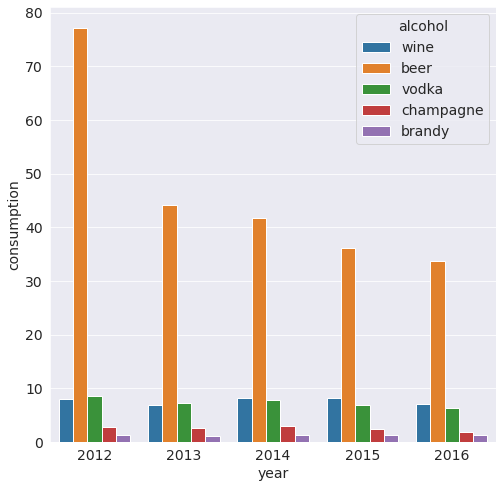

In [12]:
# See the exemplary Saint Petersburg region
Saint_Petersburg_only = df_5_years[df_5_years['region'] == 'Saint Petersburg'].drop('region', axis = 1)

St_Peter = pd.melt(Saint_Petersburg_only, id_vars= "year", var_name="alcohol", value_name="consumption")
sns.barplot(x = 'year', y = 'consumption', hue = 'alcohol', data = St_Peter)
plt.show()

We can see that there's a declining trend beer over the past 5 years, for the other categories it also seems that there's a decline also from 2014-2016. 

In [13]:
# Count the number of years of data that are available for each region
years_of_data = df_5_years.groupby('region')['year'].count()

# To make meaningful plot and data exploration, we'll combine the data so that each region is only reprensented once
sum_by_region = df_5_years.groupby('region')[alcohol].sum()
sum_by_region['years_data'] = years_of_data

# Create an dataframe that comprises of the averages of the last 5 years across all regions
average_by_region = sum_by_region[alcohol].div(sum_by_region['years_data'], axis = 0)
print(average_by_region)

                                wine   beer  vodka  champagne  brandy
region                                                               
Altai Krai                      4.50  54.12   6.84       1.10    0.34
Altai Republic                  4.48  48.78   8.42       1.08    0.38
Amur Oblast                     6.16  62.50   8.90       1.68    0.58
Arkhangelsk Oblast              9.30  52.70  13.12       2.04    1.00
Astrakhan Oblast                4.64  59.48   6.36       0.98    0.64
...                              ...    ...    ...        ...     ...
Vologda Oblast                  9.02  67.26  11.62       1.22    0.66
Voronezh Oblast                 6.26  65.38   5.96       1.72    0.56
Yamalo-Nenets Autonomous Okrug  5.24  88.46  10.76       2.12    1.52
Yaroslavl Oblast                9.34  58.12  10.24       1.58    1.00
Zabaykalsky Krai                6.52  46.80   9.86       1.02    0.34

[84 rows x 5 columns]


In [14]:
# To make comparison over the last 5 years across Russia, we'll combine all the data by year
average_by_year = df_5_years.groupby('year').mean()
print(average_by_year)

          wine       beer      vodka  champagne    brandy
year                                                     
2012  6.566667  65.960494  11.144444   1.782716  0.828395
2013  5.824691  63.665432   9.528395   1.706173  0.802469
2014  6.296088  56.057143   7.541204   1.572279  0.748810
2015  6.032993  50.609524   6.613823   1.429422  0.679762
2016  5.909639  49.486747   6.625301   1.334940  0.671084


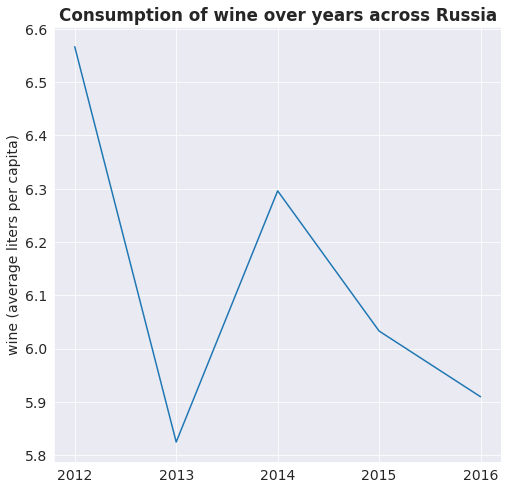

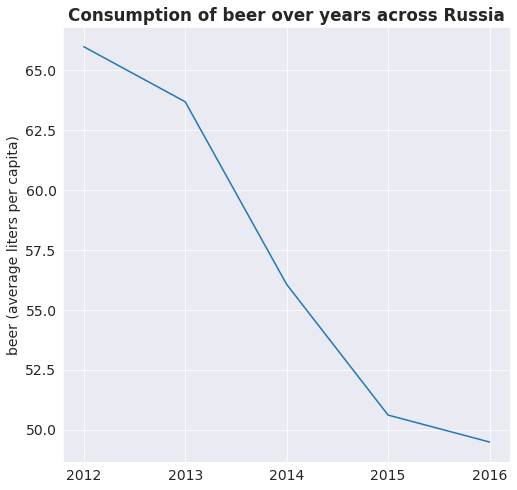

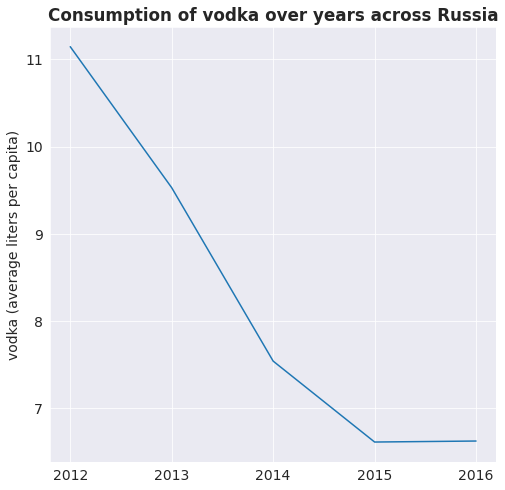

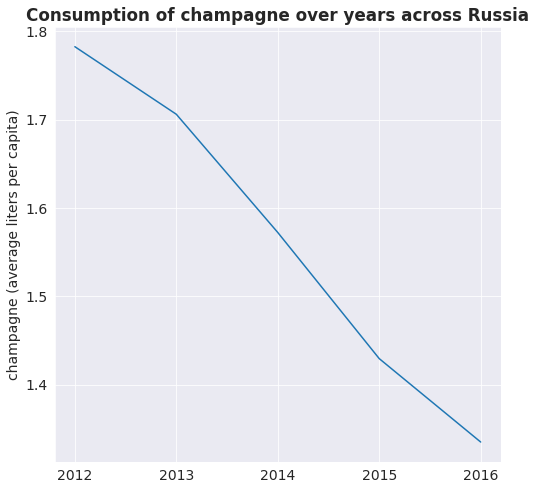

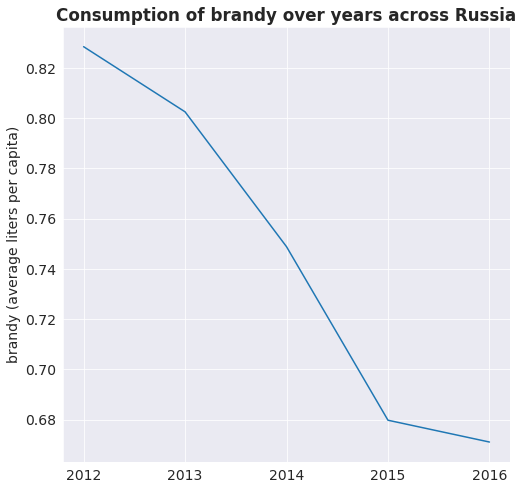

In [15]:
# See the trend over the last 5 years across different categories across Russia
last_5_years = ['2012', '2013', '2014', '2015', '2016']
for drink in alcohol:
    sns.lineplot(x = last_5_years, y = drink, data = average_by_year)
    plt.title('Consumption of ' + drink + ' over years across Russia')
    plt.ylabel(drink + ' (average liters per capita)')
    plt.show()

It seems that there's a downtrend of consumption of alcoholic beverages all over Russia in the past 5 years.
Something must have happened in the economy in 2012-2016 for that to happen. Or it could be the case that consumers are drinking non-alcoholic beverages more during this period, we'll need more actual data from 2012-2016 in order to answer that question.  

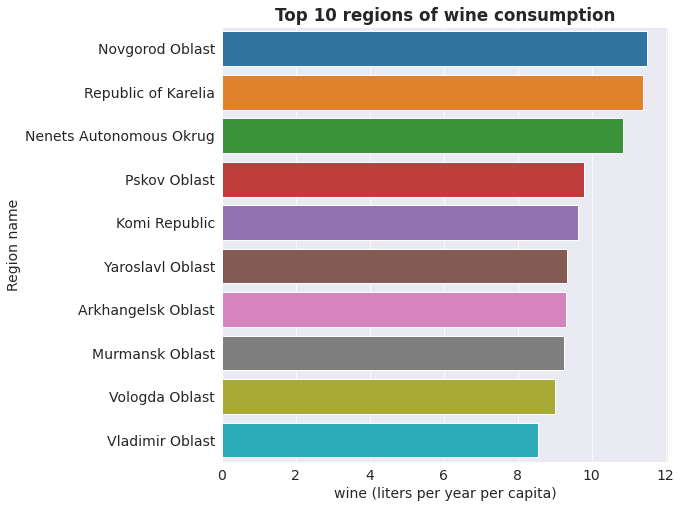

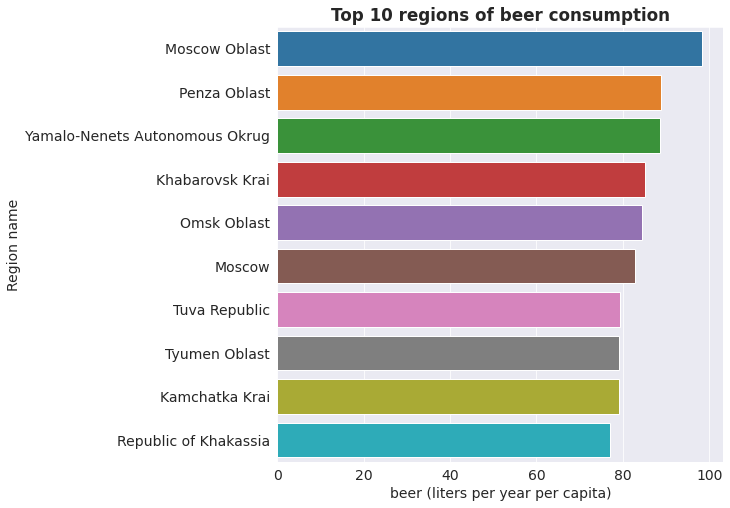

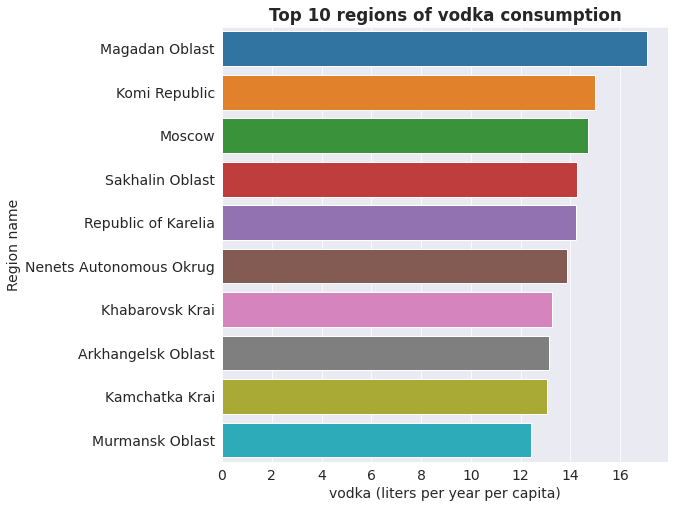

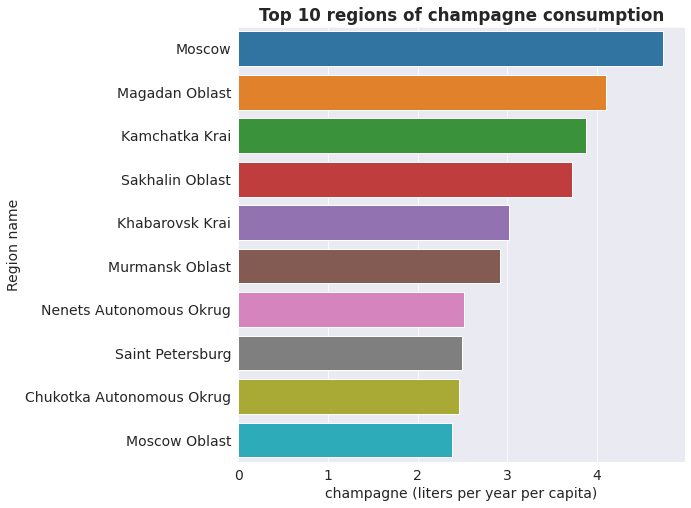

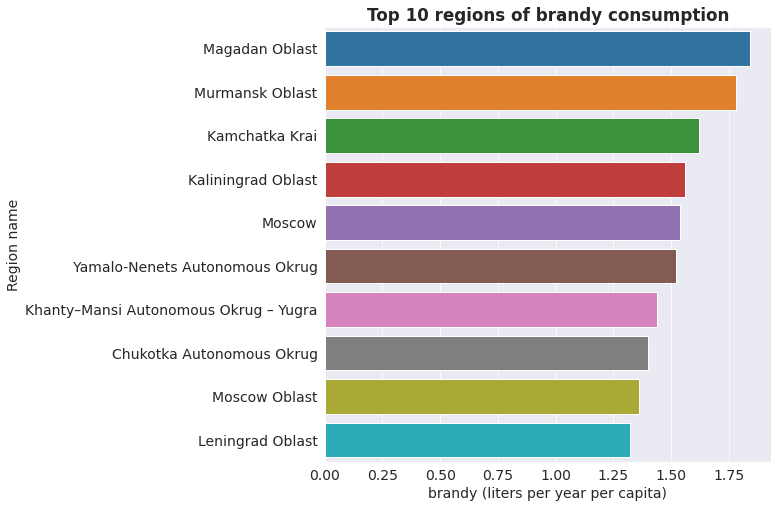

In [16]:
# Plot the top 10 regions by average consumption for each alcoholic beverage
for drink in alcohol:
    sns.barplot(x = drink, y = average_by_region.nlargest(10, drink).index, data = average_by_region.nlargest(10, drink))
    plt.title('Top 10 regions of ' + drink + ' consumption')
    plt.ylabel('Region name')
    plt.xlabel(drink + ' (liters per year per capita)')
    plt.show()

From the graphs above, we can see that Saint Petersburg is only in the top 10 just 1 category: 
- Ranked 8th for champagne

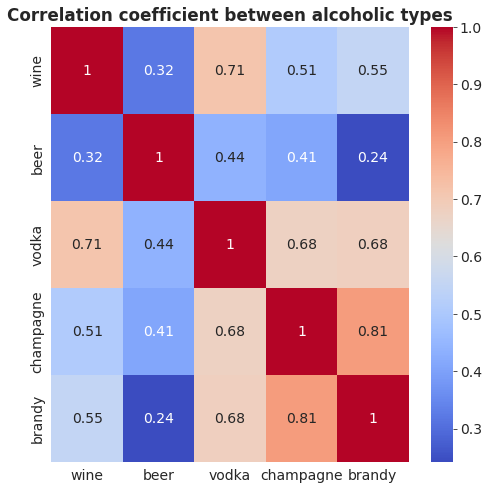

In [17]:
# Graph to see the correlation between variables 
corr = average_by_region.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='coolwarm', annot = True)
plt.title('Correlation coefficient between alcoholic types')
plt.show()

There're strong positive correlation between brandy and champagne. I.e. people who buy/drink brandy will most likely buy/drink champagne as well. 'Vodka and wine' and 'vodka and champagne' also have positive correlations. 

# Clustering
We will use hierarchical clustering to find which cluster Saint Petersburg belong to

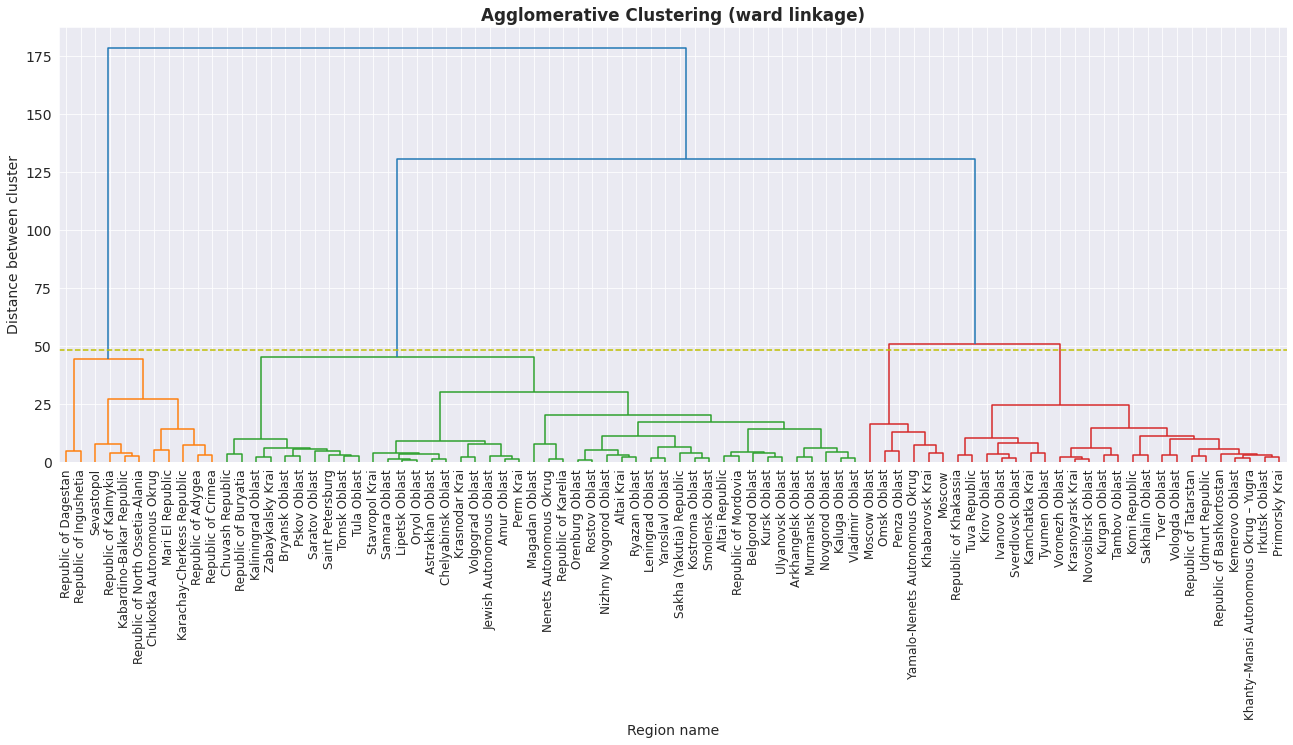

In [18]:
# Plot a dendrogram using ward linkage
plt.subplots(figsize=(22, 8))
hierarchy_5_years = linkage(average_by_region, method= 'ward')
dendrogram(hierarchy_5_years, labels = average_by_region.index, leaf_rotation=90, leaf_font_size=12)
plt.title('Agglomerative Clustering (ward linkage)')
plt.xlabel('Region name')
plt.ylabel('Distance between cluster')
plt.axhline(y=48, color='y', linestyle='--')
plt.show()

Saint Petersburg is in the green cluster in the dendrogram above. Using the cut-off point (yellow dotted line) that cuts the tallest distance cluster, we get the number of clusters to be 4 (the number of lines that the yellow line crosses is the number of clusters). So  we will use that to form the clusters in the next step.

In [19]:
recent_labels = fcluster(hierarchy_5_years, 4, criterion='maxclust')
avg_region_hierarchy = average_by_region.assign(hierarchy_cluster=recent_labels)
avg_region_hierarchy

,wine,beer,vodka,champagne,brandy,hierarchy_cluster
region,,,,,,
Altai Krai,4.50,54.12,6.84,1.10,0.34,2
Altai Republic,4.48,48.78,8.42,1.08,0.38,2
Amur Oblast,6.16,62.50,8.90,1.68,0.58,2
Arkhangelsk Oblast,9.30,52.70,13.12,2.04,1.00,2
Astrakhan Oblast,4.64,59.48,6.36,0.98,0.64,2
...,...,...,...,...,...,...
Vologda Oblast,9.02,67.26,11.62,1.22,0.66,4
Voronezh Oblast,6.26,65.38,5.96,1.72,0.56,4
Yamalo-Nenets Autonomous Okrug,5.24,88.46,10.76,2.12,1.52,3


In [20]:
# Find out what cluster Saint Petersburg belong to
avg_region_hierarchy = avg_region_hierarchy.reset_index()
avg_region_hierarchy[avg_region_hierarchy['region'] == 'Saint Petersburg']

,region,wine,beer,vodka,champagne,brandy,hierarchy_cluster
60,Saint Petersburg,7.64,46.6,7.34,2.5,1.22,2


So Saint Petersburg belongs to cluster 2. We'll see what other regions belong to this cluster.

['Altai Krai', 'Altai Republic', 'Amur Oblast', 'Arkhangelsk Oblast', 'Astrakhan Oblast', 'Belgorod Oblast', 'Bryansk Oblast', 'Chelyabinsk Oblast', 'Chuvash Republic', 'Jewish Autonomous Oblast', 'Kaliningrad Oblast', 'Kaluga Oblast', 'Kostroma Oblast', 'Krasnodar Krai', 'Kursk Oblast', 'Leningrad Oblast', 'Lipetsk Oblast', 'Magadan Oblast', 'Murmansk Oblast', 'Nenets Autonomous Okrug', 'Nizhny Novgorod Oblast', 'Novgorod Oblast', 'Orenburg Oblast', 'Oryol Oblast', 'Perm Krai', 'Pskov Oblast', 'Republic of Buryatia', 'Republic of Karelia', 'Republic of Mordovia', 'Rostov Oblast', 'Ryazan Oblast', 'Saint Petersburg', 'Sakha (Yakutia) Republic', 'Samara Oblast', 'Saratov Oblast', 'Smolensk Oblast', 'Stavropol Krai', 'Tomsk Oblast', 'Tula Oblast', 'Ulyanovsk Oblast', 'Vladimir Oblast', 'Volgograd Oblast', 'Yaroslavl Oblast', 'Zabaykalsky Krai']
44


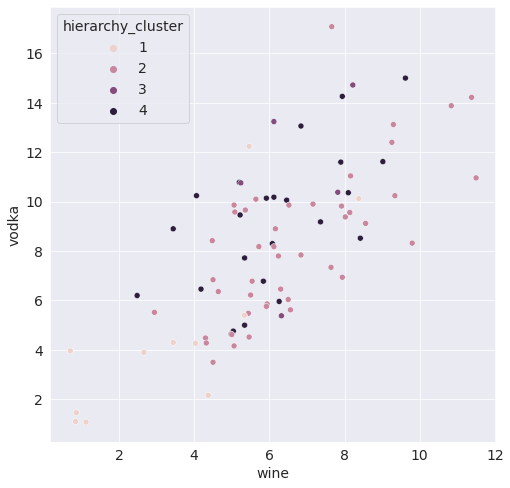

In [21]:
avg_recent_list = avg_region_hierarchy.loc[avg_region_hierarchy['hierarchy_cluster'] == 2, 'region'].tolist()
print(avg_recent_list)
print(len(avg_recent_list))

sns.scatterplot(x = 'wine', y = 'vodka', hue = 'hierarchy_cluster', data = avg_region_hierarchy)
plt.show()

Since there are 43 regions that are similar to Saint Petersburg, we will take an additional step using cosine similarity to filter down to just 10 regions. 

In [22]:
# See which regions are in the same cluster with Saint Petersburg
St_Peter_cluster = avg_region_hierarchy[avg_region_hierarchy['region'].isin(avg_recent_list)]
# Set region as index and drop the 'hierarchy_cluster' column
St_Peter_cluster.set_index('region', inplace = True)
St_Peter_cluster.drop('hierarchy_cluster', axis = 1, inplace = True)
print(St_Peter_cluster)

                           wine   beer  vodka  champagne  brandy
region                                                          
Altai Krai                 4.50  54.12   6.84       1.10    0.34
Altai Republic             4.48  48.78   8.42       1.08    0.38
Amur Oblast                6.16  62.50   8.90       1.68    0.58
Arkhangelsk Oblast         9.30  52.70  13.12       2.04    1.00
Astrakhan Oblast           4.64  59.48   6.36       0.98    0.64
Belgorod Oblast            2.94  49.50   5.52       1.16    0.44
Bryansk Oblast             7.94  42.94   6.94       1.30    0.48
Chelyabinsk Oblast         5.54  59.42   6.78       1.66    0.60
Chuvash Republic           5.64  41.86  10.10       0.86    0.48
Jewish Autonomous Oblast   5.08  60.30   9.58       1.58    0.46
Kaliningrad Oblast         7.92  45.96   9.82       1.58    1.56
Kaluga Oblast              8.14  50.62   9.56       1.72    0.90
Kostroma Oblast            7.16  54.50   9.90       1.14    0.52
Krasnodar Krai           

In [23]:
# Calculate the similarity between regions and return a numpy
similarity_np = cosine_similarity(St_Peter_cluster)

# Convert to df
region_similarity = pd.DataFrame(similarity_np, index = St_Peter_cluster.index, columns = St_Peter_cluster.index)

# Get the regions that are most similar to Saint Petersburg
similar_10_Saint_Petersburg = region_similarity['Saint Petersburg'].nlargest(11)
print(similar_10_Saint_Petersburg)
similar_10_hierarchy = list(similar_10_Saint_Petersburg.index)

region
Saint Petersburg          1.000000
Smolensk Oblast           0.999578
Yaroslavl Oblast          0.999461
Bryansk Oblast            0.999424
Tomsk Oblast              0.999330
Kaluga Oblast             0.999322
Vladimir Oblast           0.999134
Leningrad Oblast          0.999022
Kostroma Oblast           0.998582
Nizhny Novgorod Oblast    0.998574
Tula Oblast               0.998558
Name: Saint Petersburg, dtype: float64


The 10 Oblasts above seem to be the most similar to Saint Petersburg

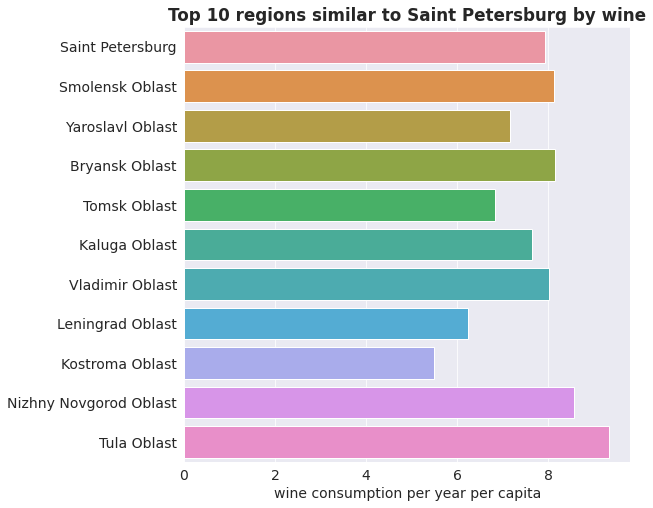

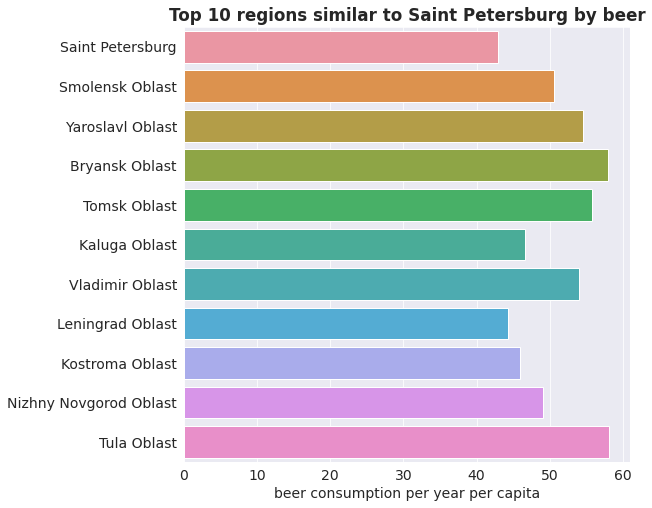

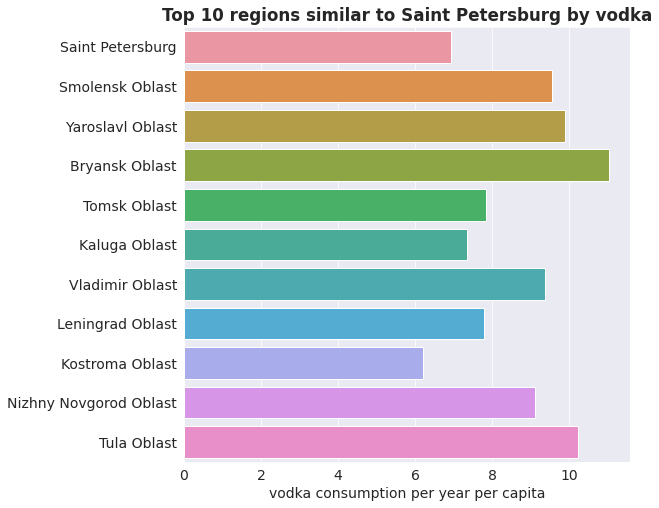

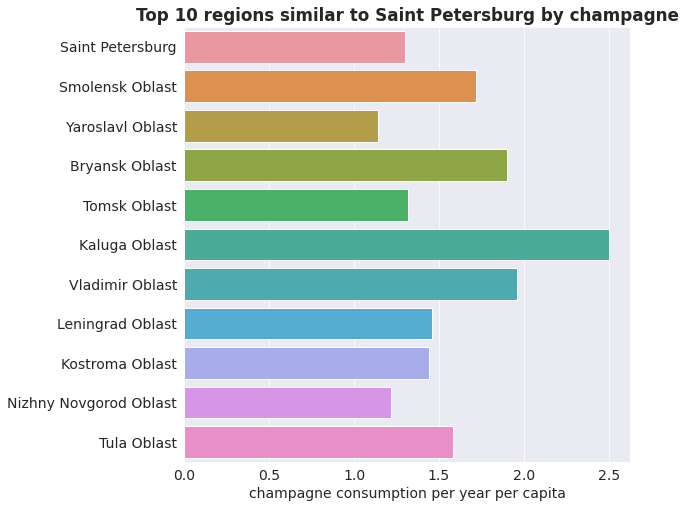

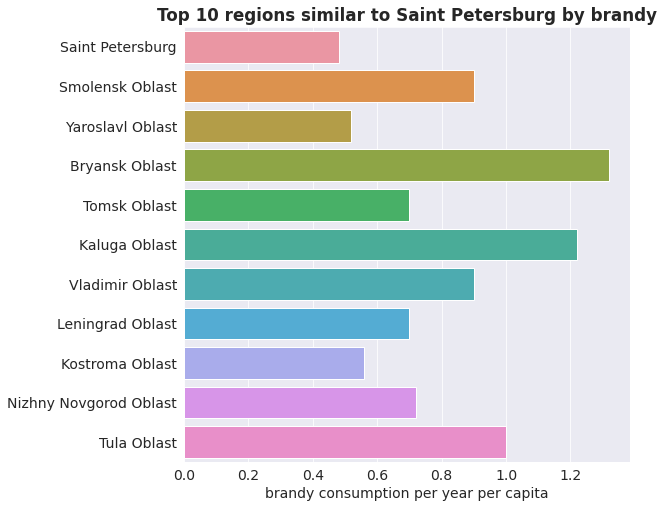

In [24]:
# Graph these 10 regions based on cosine similarity to see
for drink in alcohol:
    sns.barplot(x = drink, y = similar_10_hierarchy, 
            data = average_by_region[average_by_region.index.isin(similar_10_hierarchy)])
    plt.title('Top 10 regions similar to Saint Petersburg by ' + drink)
    plt.xlabel(drink + ' consumption per year per capita')
    plt.show()

# Collaborative filtering
Next, we will use a different method to find the regions that are similar to Saint Petersburg, using Euclidean distances.

In [25]:
# Calculate Euclidean distance between regions
dist = DistanceMetric.get_metric('euclidean')
region_Euclidean_similar = pd.DataFrame(dist.pairwise(average_by_region), index = average_by_region.index, columns = average_by_region.index)

Euclidean_distance_Saint_Petersburg = region_Euclidean_similar['Saint Petersburg']

# Convert to similarity
similar_to_Saint_Petersburg = 1/(1 + Euclidean_distance_Saint_Petersburg)
# Get the top 10
similar_top_10_Saint_Petersburg = similar_to_Saint_Petersburg.nlargest(11)
print(similar_top_10_Saint_Petersburg)
similar_10_distance = list(similar_top_10_Saint_Petersburg.index)
print(similar_10_distance)

region
Saint Petersburg      1.000000
Kaliningrad Oblast    0.266178
Tula Oblast           0.262625
Tomsk Oblast          0.253943
Zabaykalsky Krai      0.234894
Vladimir Oblast       0.222197
Pskov Oblast          0.217439
Kursk Oblast          0.213879
Bryansk Oblast        0.201862
Ulyanovsk Oblast      0.193095
Altai Republic        0.188117
Name: Saint Petersburg, dtype: float64
['Saint Petersburg', 'Kaliningrad Oblast', 'Tula Oblast', 'Tomsk Oblast', 'Zabaykalsky Krai', 'Vladimir Oblast', 'Pskov Oblast', 'Kursk Oblast', 'Bryansk Oblast', 'Ulyanovsk Oblast', 'Altai Republic']


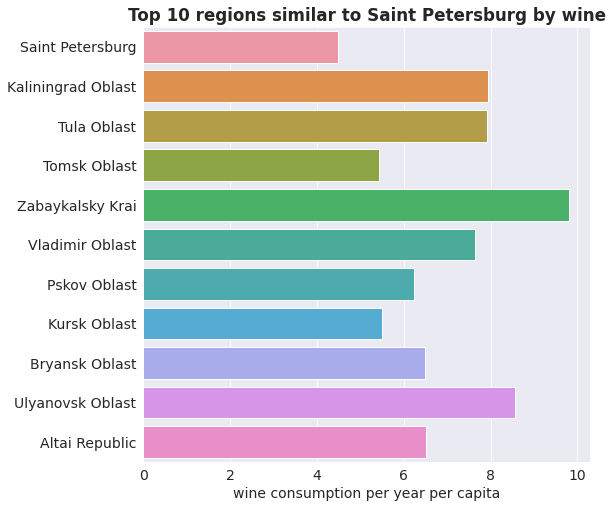

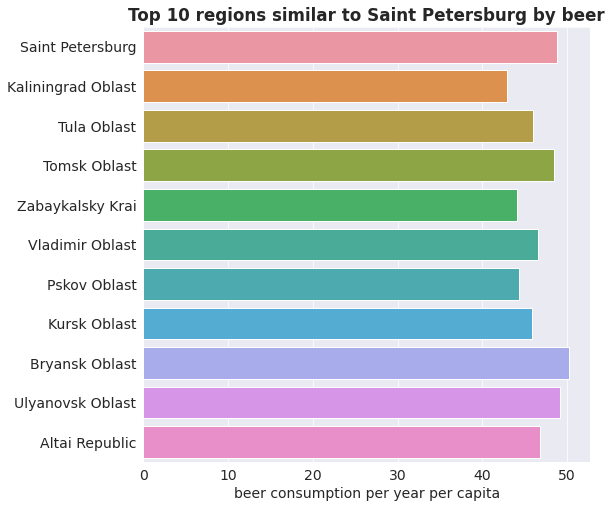

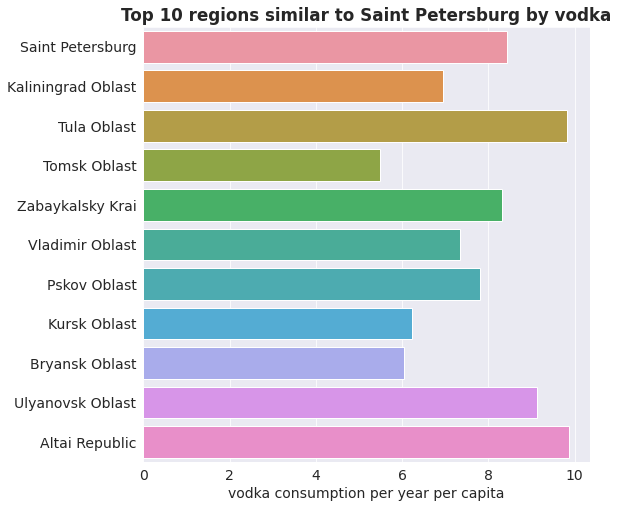

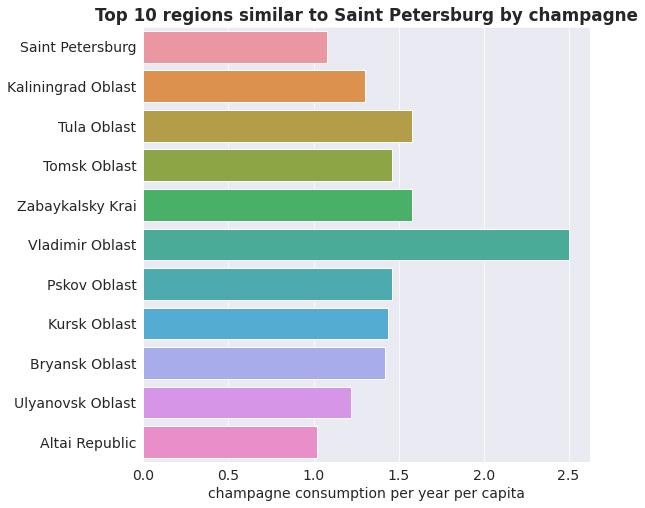

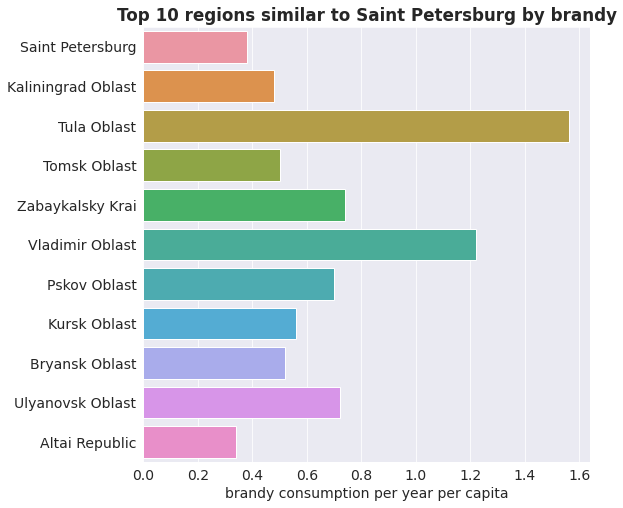

In [26]:
# Graph these 10 regions to see
for drink in alcohol:
    sns.barplot(x = drink, y = similar_10_distance, 
            data = average_by_region[average_by_region.index.isin(similar_10_distance)])
    plt.title('Top 10 regions similar to Saint Petersburg by ' + drink)
    plt.xlabel(drink + ' consumption per year per capita')
    plt.show()

We'll see what regions are there in common between the 2 methods.

In [27]:
# First we'll remove Saint Petersburg from these 2 lists
similar_10_hierarchy.remove('Saint Petersburg')
similar_10_distance.remove('Saint Petersburg')

In [28]:
common_regions = []
for region in similar_10_hierarchy:
    if region in similar_10_distance:
        common_regions.append(region)

# Get the regions that are only in each method
hierarchy_only = list(set(similar_10_hierarchy) - set(similar_10_distance))
distance_only = list(set(similar_10_distance) - set(similar_10_hierarchy))
print('The regions that are common in both methods are', common_regions)
print('The regions that are similar to Saint Petersburg as a result of hierarchical clustering are', hierarchy_only)
print('The regions that are similar to Saint Petersburg as a result of Euclidean distance are', distance_only)

The regions that are common in both methods are ['Bryansk Oblast', 'Tomsk Oblast', 'Vladimir Oblast', 'Tula Oblast']
The regions that are similar to Saint Petersburg as a result of hierarchical clustering are ['Yaroslavl Oblast', 'Kaluga Oblast', 'Kostroma Oblast', 'Nizhny Novgorod Oblast', 'Smolensk Oblast', 'Leningrad Oblast']
The regions that are similar to Saint Petersburg as a result of Euclidean distance are ['Pskov Oblast', 'Kursk Oblast', 'Altai Republic', 'Kaliningrad Oblast', 'Ulyanovsk Oblast', 'Zabaykalsky Krai']


# Conclusion and recommendation

Each method above has its pros and cons. For the purpose of recommending to the marketing deparment, I think the hierarchical clustering + cosine similarity may make more economic sense as grouping by hierarchical clustering ensures that those regions are more likely to be similar already, whereas Euclidean distance may give more weights to regions where consumption of GDP per capita in a certain category of beverages may skew the results for the other categories. 

In [29]:
# Below are the 10 regions that the marketing team should focus their effort on
print(similar_10_hierarchy)

['Smolensk Oblast', 'Yaroslavl Oblast', 'Bryansk Oblast', 'Tomsk Oblast', 'Kaluga Oblast', 'Vladimir Oblast', 'Leningrad Oblast', 'Kostroma Oblast', 'Nizhny Novgorod Oblast', 'Tula Oblast']
